XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.
Test generalization by training and testing on different stations

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190728-090436'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
landcover, landcover_legend = load_data.load_landcover_reduced()

../src/load_data.py:242: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  landcover_fullres = np.array(landcover_nc['Band1'][:])[::-1,:]


In [4]:
station_cell_mapping = load_data.get_station_cell_mapping()

In [5]:
for station in station_data_dict.keys():
    for i in range(len(landcover_legend)):
        for row_col in station_cell_mapping[station_cell_mapping['station'] == station][['row','col']].values:
            cell_id = 39 * (row_col[1] - 1) + (row_col[0] - 1)
            station_data_dict[station]['{}_{}'.format(landcover_legend[i], cell_id)] = landcover[i,row_col[1]-1,row_col[0]-1]

In [6]:
test_station_fraction = 0.25
num_test_stations = int(len(station_data_dict.keys()) * test_station_fraction)
test_stations = np.random.choice(list(station_data_dict.keys()), size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if s not in test_stations))
train_stations, test_stations

(array(['02GA010', '02GA018', '02GA038', '02GA047', '02GB007', '02GC002',
        '02GC007', '02GC010', '02GC018', '02GE007', '02GG002', '02GG003',
        '02GG006', '02GG009', '02GG013', '04159492', '04159900',
        '04161820', '04165500', '04166100', '04174500', '04176500',
        '04198000', '04199000', '04199500', '04200500', '04207200',
        '04208504', '04209000', '04212100', '04213000', '04213500',
        '04214500', '04215000', '04215500'], dtype='<U8'),
 array(['04166500', '04164000', '04177000', '02GB001', '02GC026',
        '04196800', '04193500', '02GD004', '04160600', '04197100',
        '04195820'], dtype='<U8'))

In [7]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(train_stations))].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()
    
test = data[(data['date'] >= test_start) & (data['date'] <= test_end) & (data['station'].isin(test_stations))].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

m = xgb.XGBRegressor(n_estimators=800, n_jobs=32, random_state=123, colsample_bylevel=.8357617548460161,
                    colsample_bytree=0.7279736118769715, gamma=0.6959743989532903, learning_rate=0.1456725523229726, max_depth=3, min_child_weight=5,
                     reg_alpha=45.191905388077004, reg_lambda=8.021568667278883, subsample=0.9708847409794326)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)

test = test[~pd.isna(test['runoff'])]

predict = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
predict['is_test_station'] = predict['station'].apply(lambda s: s in test_stations)
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'is_test_station'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Shapes: train (33309, 15624), val (3701, 15624), test (8030, 15624)


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


02GA010 	NSE: 0.3022071879808821 	MSE: 332.6891549429223 (clipped to 0)
02GA018 	NSE: 0.30141237796903286 	MSE: 175.4525031324329 (clipped to 0)
02GA038 	NSE: 0.22804390893065118 	MSE: 127.01646404145713 (clipped to 0)
02GA047 	NSE: 0.0295748032451858 	MSE: 76.07165510881421 (clipped to 0)
02GB001 	NSE: -0.5773377279741425 	MSE: 11845.609483133021 (clipped to 0)
02GB007 	NSE: 0.2409278462296749 	MSE: 23.737715421054073 (clipped to 0)
02GC002 	NSE: 0.4773740143287065 	MSE: 67.15902513028763 (clipped to 0)
02GC007 	NSE: 0.24189275469566918 	MSE: 22.83520948390373 (clipped to 0)
02GC010 	NSE: 0.3235692176488214 	MSE: 40.21375576026308 (clipped to 0)
02GC018 	NSE: 0.49626334752299006 	MSE: 34.11647238347362 (clipped to 0)
02GC026 	NSE: 0.14761787463134934 	MSE: 137.09096412220507 (clipped to 0)
02GD004 	NSE: -0.000509451662032312 	MSE: 55.091125387236985 (clipped to 0)
02GE007 	NSE: 0.1597869167639202 	MSE: 30.394757421414162 (clipped to 0)
02GG002 	NSE: 0.5927957840102918 	MSE: 98.2106637

../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04160600 	NSE: 0.21997014472458387 	MSE: 22.566977789705103 (clipped to 0)
04161820 	NSE: 0.19993874171381576 	MSE: 25.264373706082203 (clipped to 0)
04164000 	NSE: 0.29760078359285846 	MSE: 123.07955870750015 (clipped to 0)
04165500 	NSE: 0.5503665703369218 	MSE: 201.28241460761842 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04166100 	NSE: -0.14735522980113158 	MSE: 8.413908925413356 (clipped to 0)
04166500 	NSE: 0.10967748009389211 	MSE: 30.7733678706625 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04174500 	NSE: 0.2847041941653581 	MSE: 67.6485547698374 (clipped to 0)
04176500 	NSE: 0.1312954593467508 	MSE: 593.3896733665207 (clipped to 0)
04177000 	NSE: -0.001375399676037059 	MSE: 26.986896598238562 (clipped to 0)
04193500 	NSE: -0.283112982476599 	MSE: 90845.36055463228 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04195820 	NSE: -0.8239810275356654 	MSE: 2140.978597757001 (clipped to 0)
04196800 	NSE: 0.06528589581448552 	MSE: 279.71178143453733 (clipped to 0)
04197100 	NSE: -1.9951425683911665 	MSE: 307.19502962422405 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04198000 	NSE: 0.5364222795033605 	MSE: 3424.7079475824107 (clipped to 0)
04199000 	NSE: 0.48700449034353266 	MSE: 524.5909009500199 (clipped to 0)
04199500 	NSE: 0.4596174876992778 	MSE: 218.6647687425805 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04200500 	NSE: 0.5329524217466124 	MSE: 467.37682620286887 (clipped to 0)
04207200 	NSE: 0.10221254231182564 	MSE: 21.01387475540443 (clipped to 0)
04208504 	NSE: 0.5316449838546401 	MSE: 457.3620945283882 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04209000 	NSE: 0.39632039917578665 	MSE: 188.7440589335554 (clipped to 0)
04212100 	NSE: 0.5131920333829485 	MSE: 714.7923257531214 (clipped to 0)
04213000 	NSE: 0.4173178814198949 	MSE: 104.57351487567504 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04213500 	NSE: 0.5506275799332452 	MSE: 460.3446760832616 (clipped to 0)
04214500 	NSE: 0.4293732175434638 	MSE: 68.78169015288715 (clipped to 0)
04215000 	NSE: 0.31292020964769696 	MSE: 65.99594649498503 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215500 	NSE: 0.4775475544861957 	MSE: 94.34702866049332 (clipped to 0)
Train Median NSE (clipped to 0) 0.4173178814198949 / Min -0.14735522980113158 / Max 0.6234060852184475
Train Median MSE (clipped to 0) 94.34702866049332 / Min 8.413908925413356 / Max 3424.7079475824107
Test Median NSE (clipped to 0) -0.000509451662032312 / Min -1.9951425683911665 / Max 0.29760078359285846
Test Median MSE (clipped to 0) 137.09096412220507 / Min 22.566977789705103 / Max 90845.36055463228


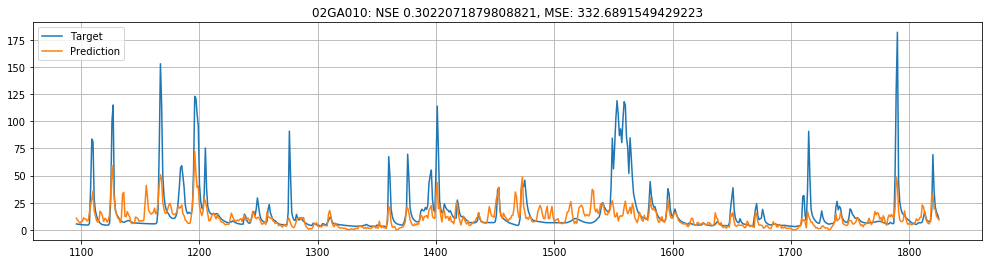

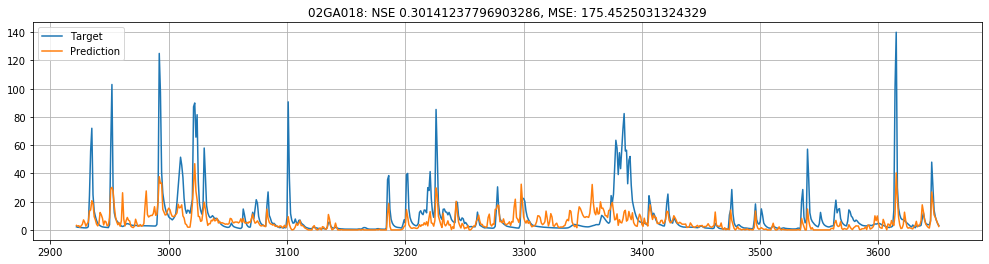

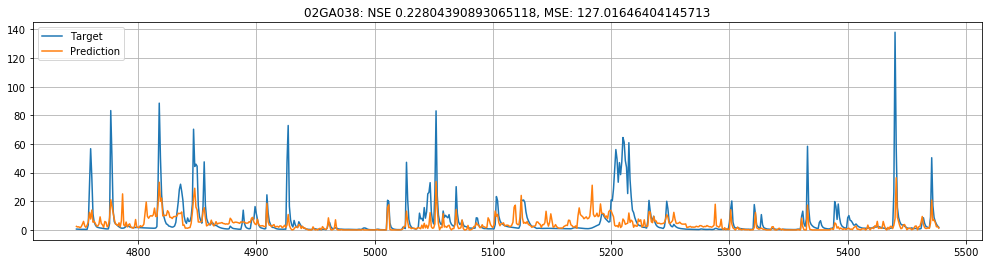

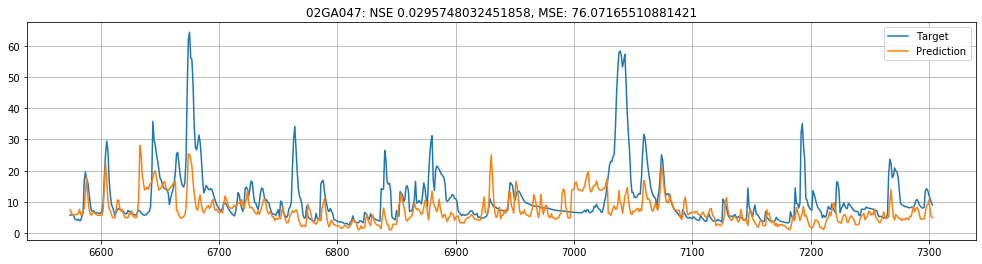

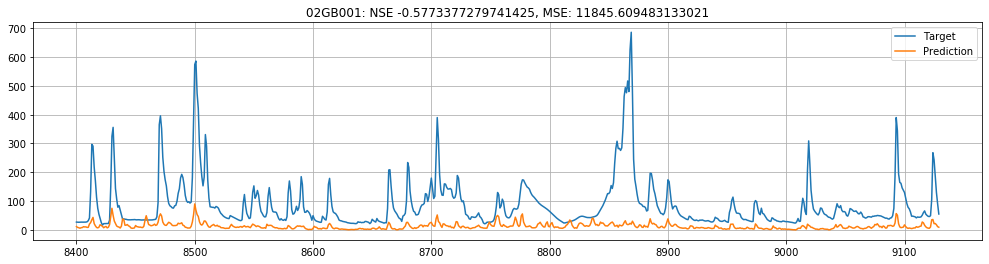

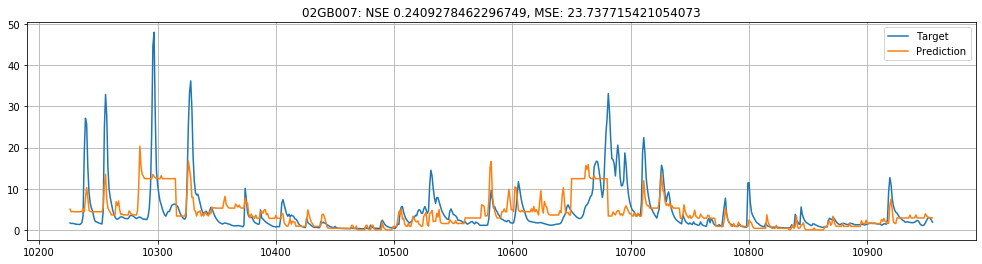

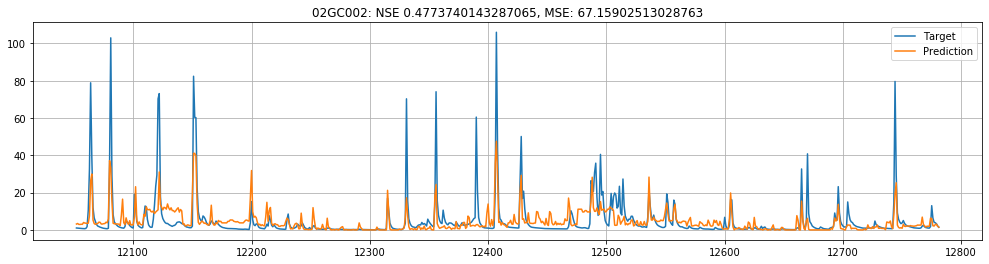

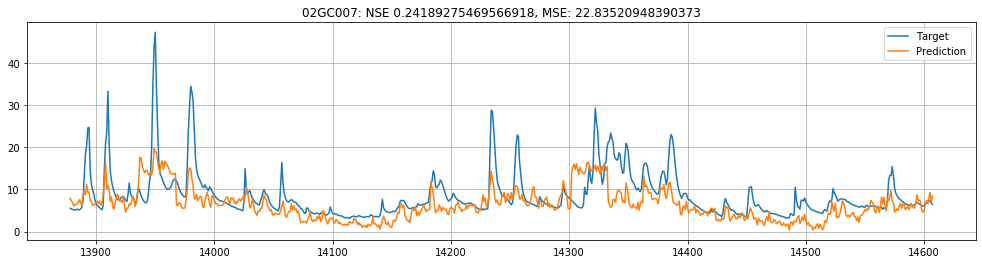

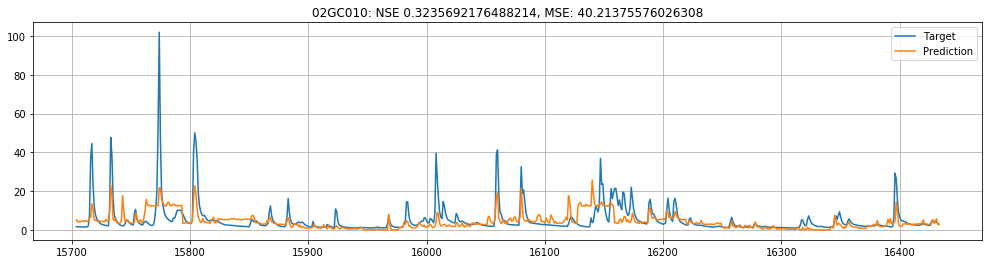

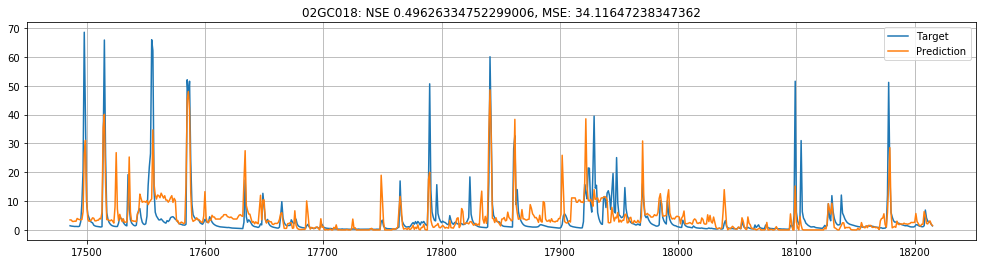

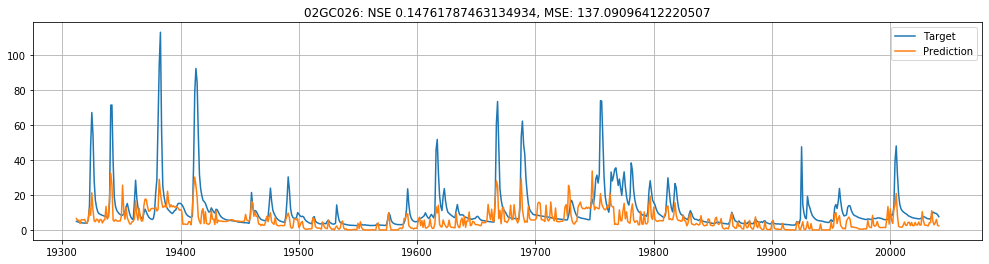

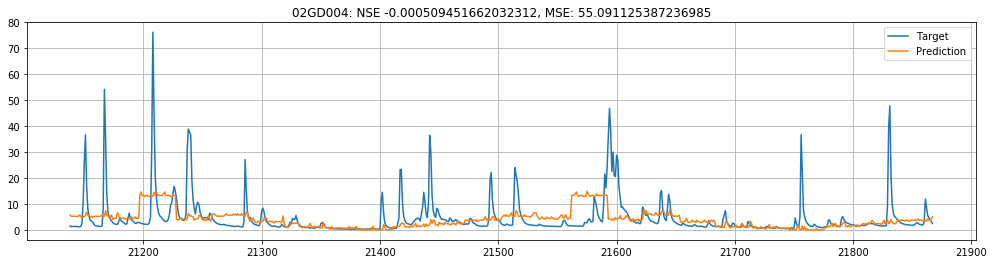

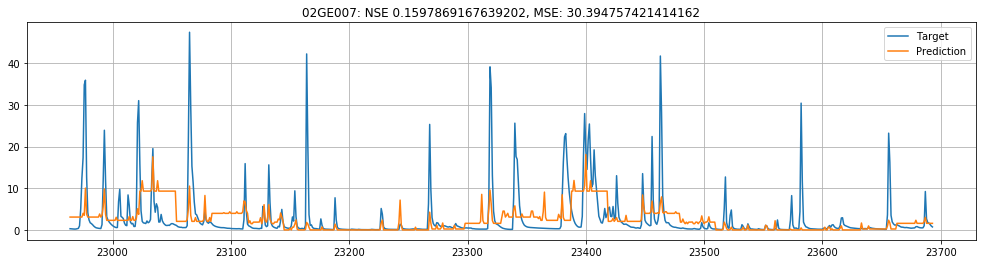

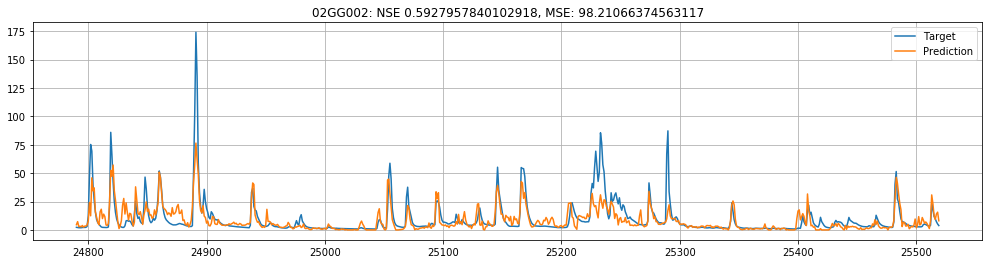

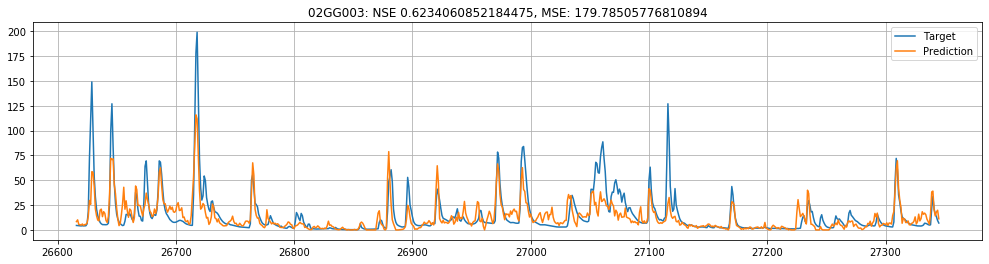

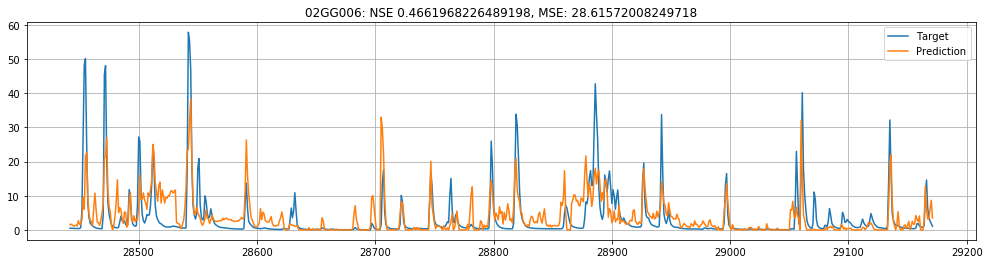

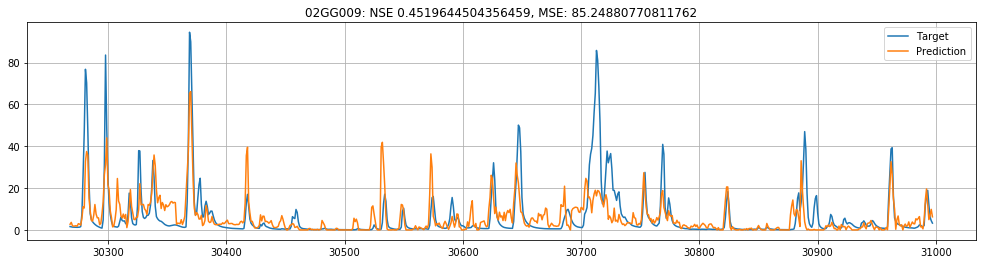

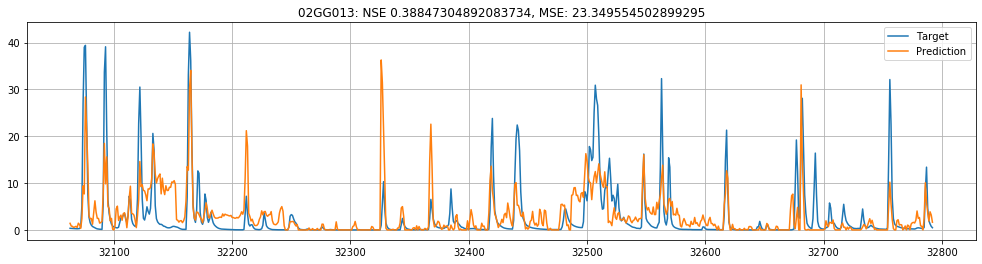

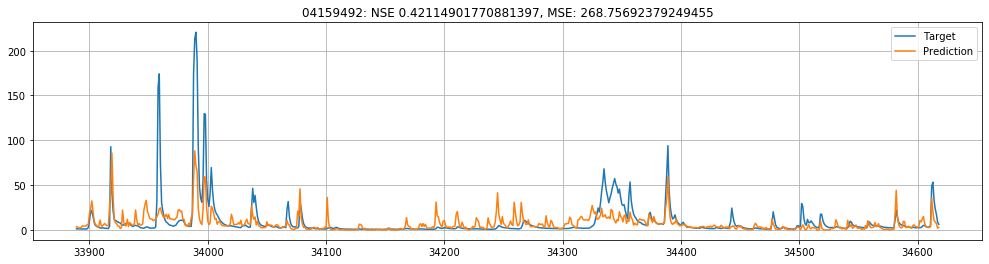

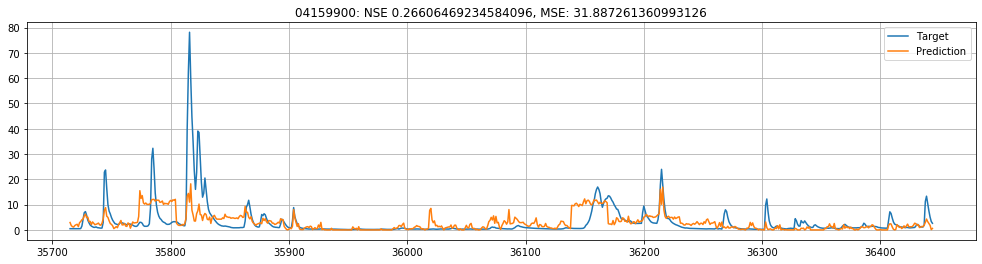

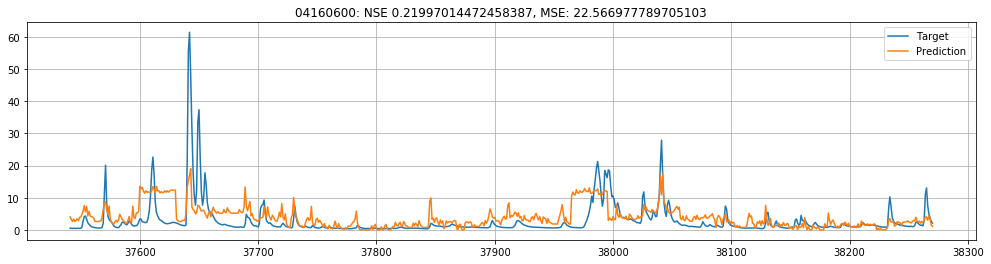

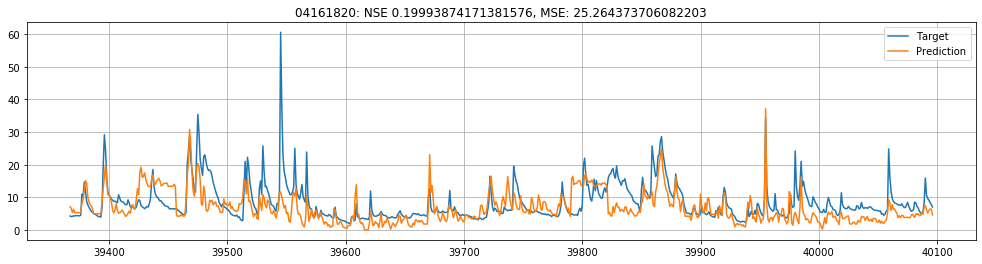

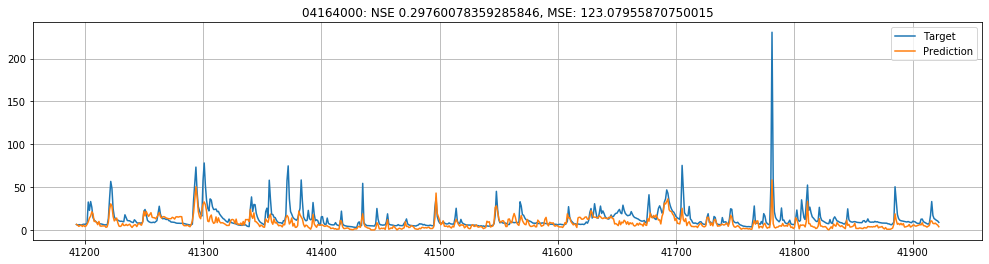

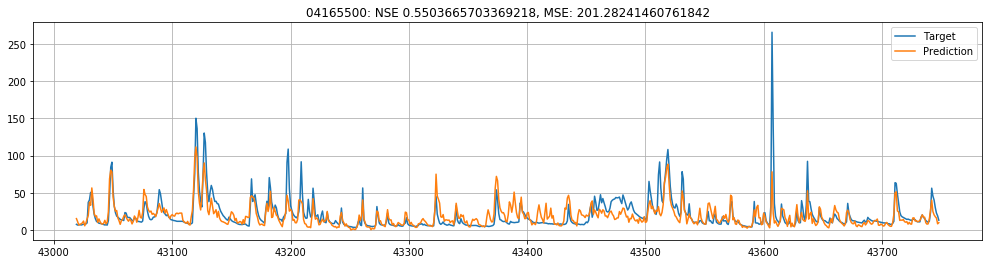

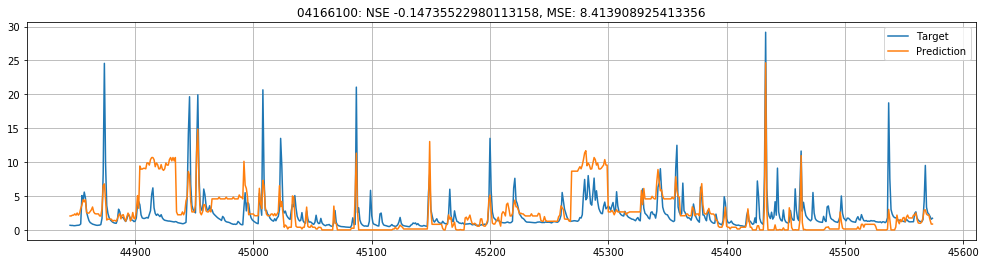

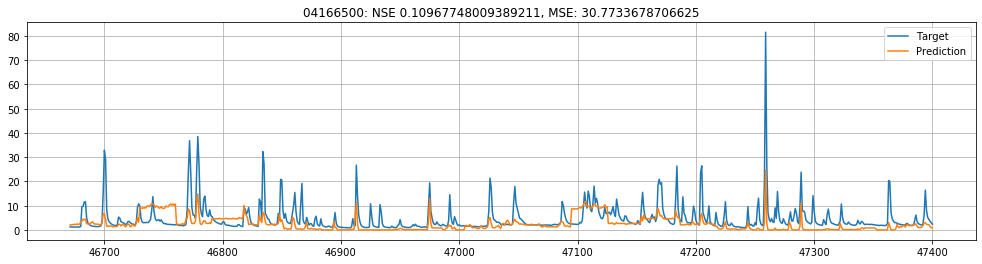

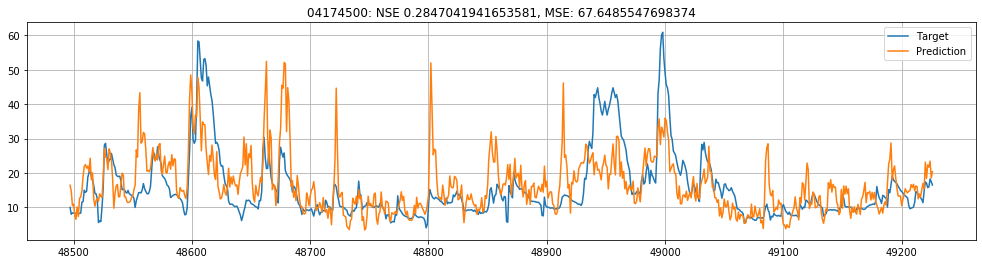

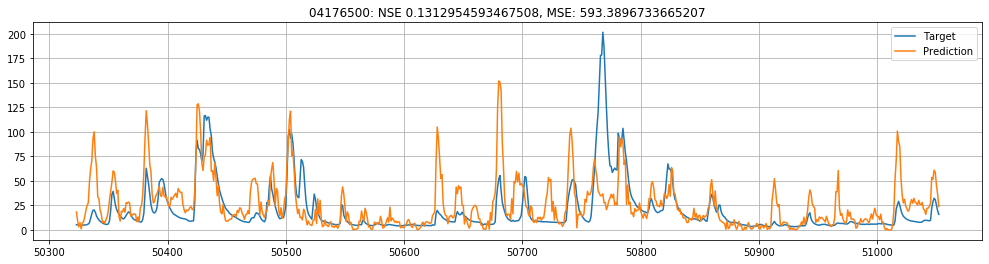

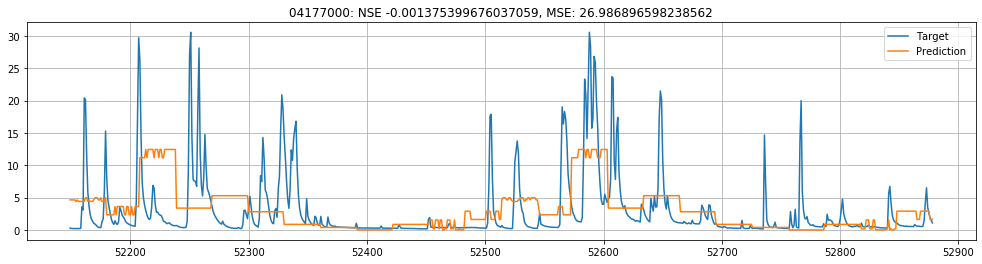

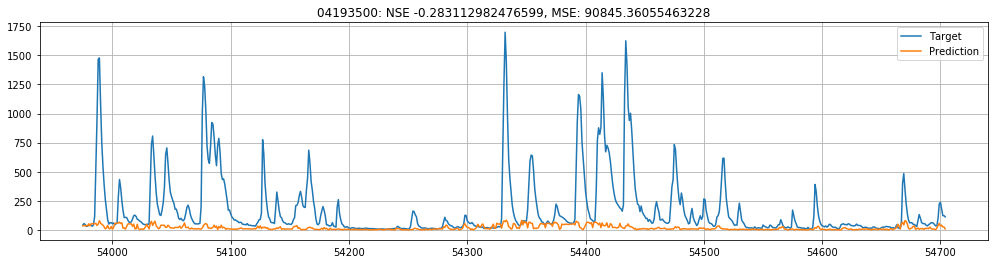

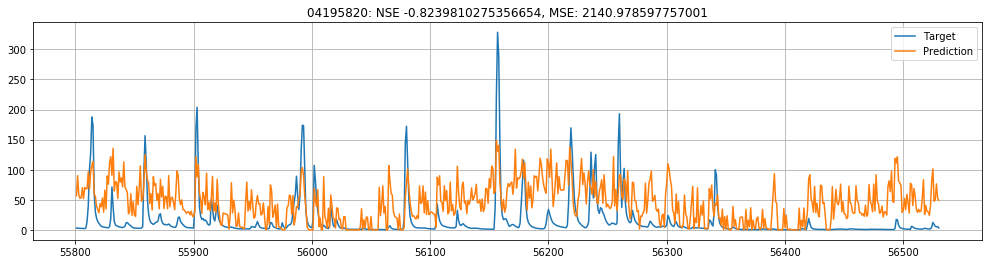

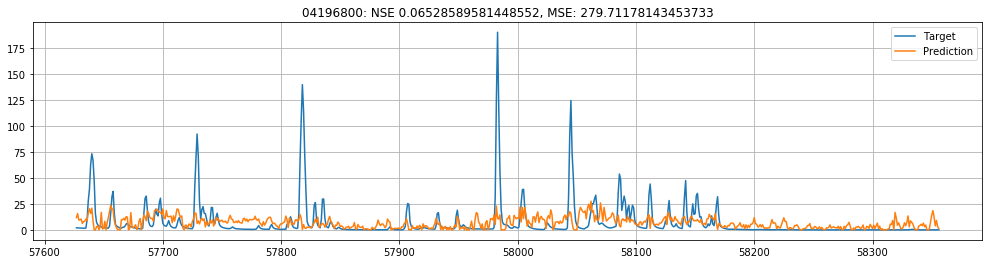

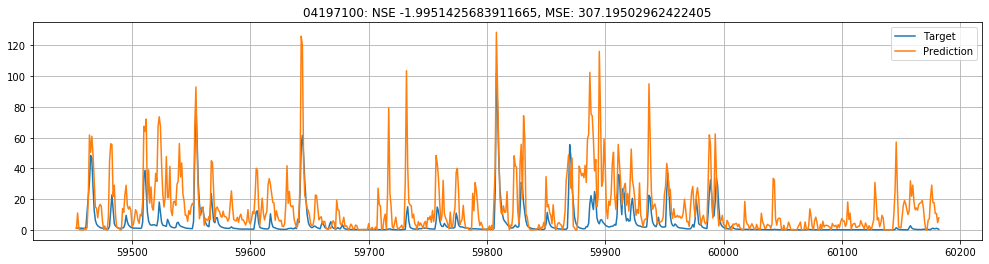

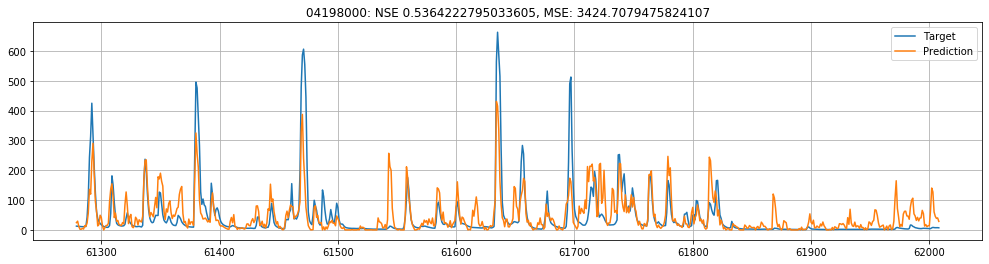

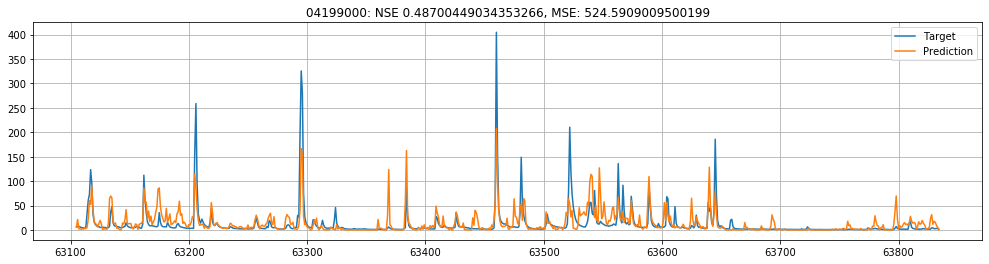

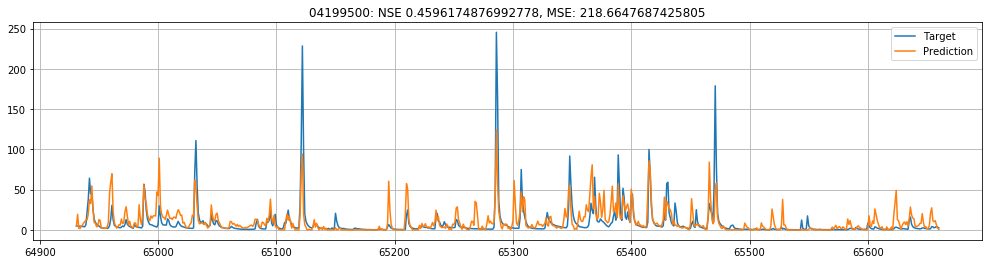

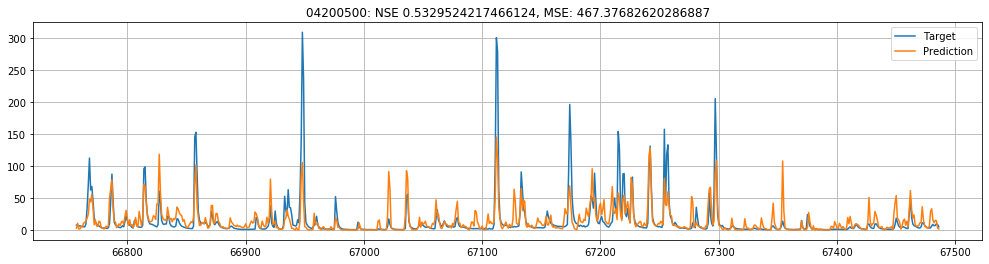

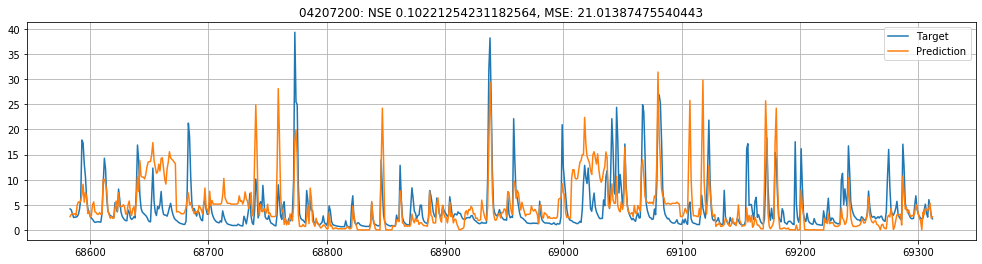

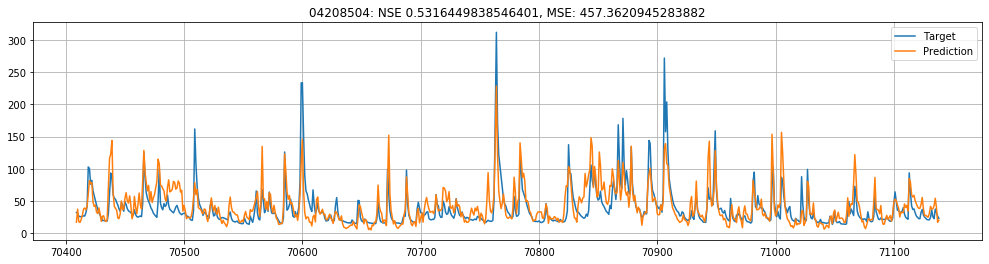

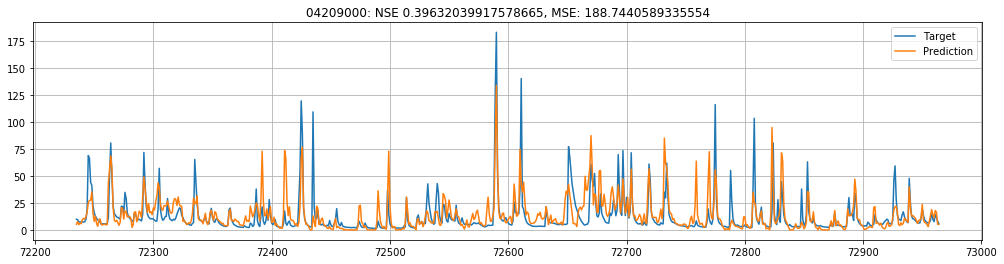

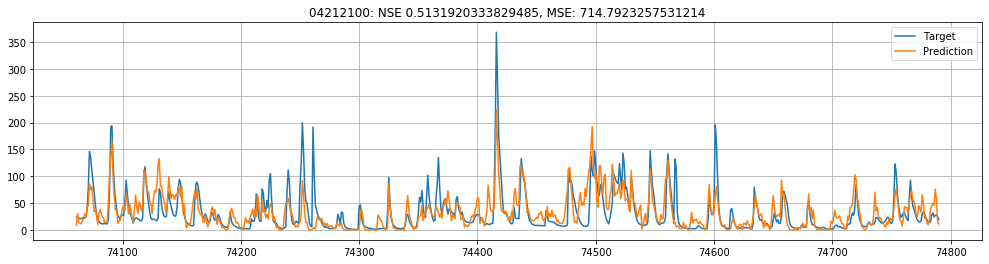

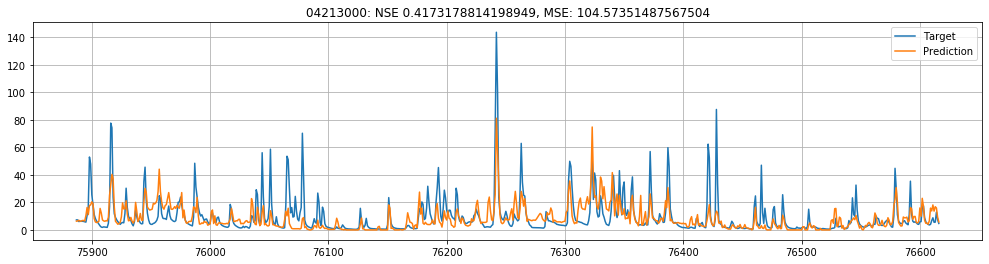

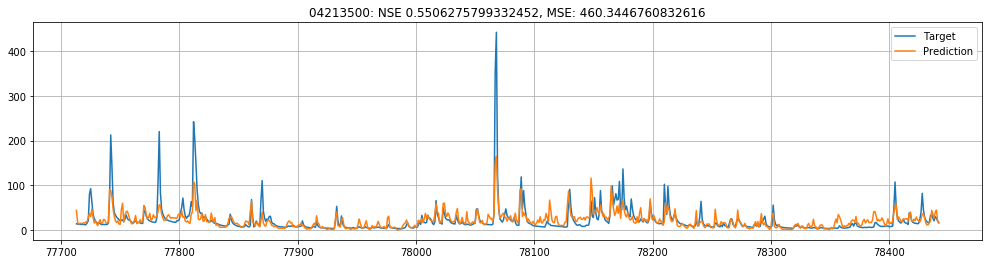

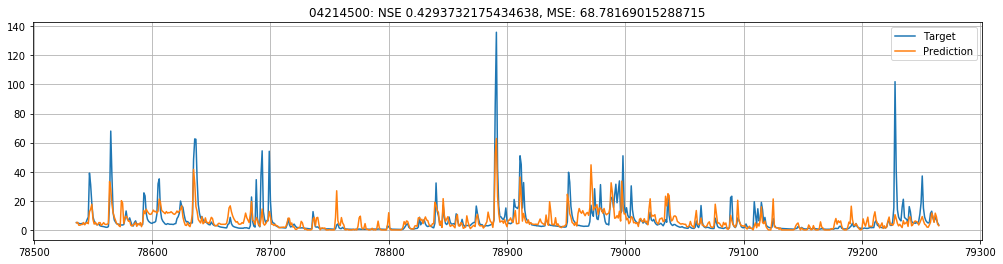

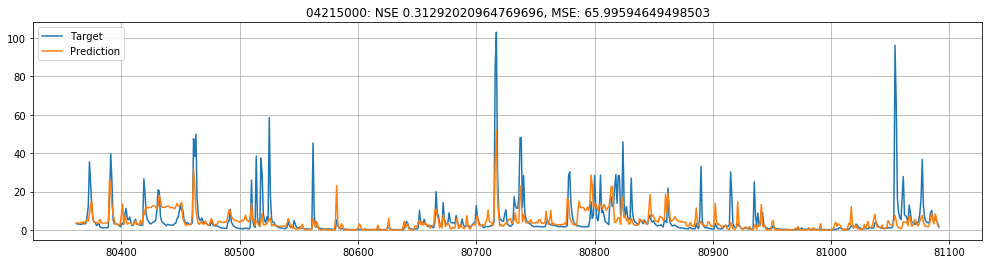

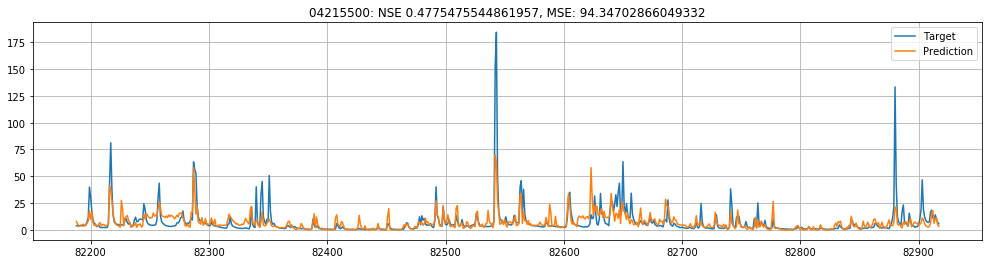

In [8]:
train_nse_list = []
train_mse_list = []
test_nse_list = []
test_mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    if station in test_stations:
        test_nse_list.append(nse)
        test_mse_list.append(mse)
    else:
        train_nse_list.append(nse)
        train_mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Train Median NSE (clipped to 0)', np.median(train_nse_list), '/ Min', np.min(train_nse_list), '/ Max', np.max(train_nse_list))
print('Train Median MSE (clipped to 0)', np.median(train_mse_list), '/ Min', np.min(train_mse_list), '/ Max', np.max(train_mse_list))
print('Test Median NSE (clipped to 0)', np.median(test_nse_list), '/ Min', np.min(test_nse_list), '/ Max', np.max(test_nse_list))
print('Test Median MSE (clipped to 0)', np.median(test_mse_list), '/ Min', np.min(test_mse_list), '/ Max', np.max(test_mse_list))

In [ ]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', predict[['date', 'station', 'runoff', 'actual', 'is_test_station']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

In [ ]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', m, 'all', time_stamp, model_type='sklearn')

In [ ]:
datetime.now().strftime('%Y%m%d-%H%M%S')